## Contenu :
### 1.  Random Forest Classifier
### 2.  K nearest neighbours Classifier

Ces algorithmes ont été essayés avec de nombreuses combinaisons de données et de variables, comme détaillé dans le rapport. Ce notebook contient le code uniquement pour le modèle finalement retenu  pour chaque algorithme. (Le code de toutes les combinaisons testées se trouve dans le branch "Deborah" du repo Github)

___________________________________________________________________________________________________________________


## Random Forest Classifier

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn import model_selection

#import des données (préparée dans le notebook "Visualisation")
df = pd.read_csv("tempdata_2016_2019.csv")
# on prend la région Hauts de France
HDF = df.loc[(df["Région"] == "Hauts-de-France")]
HDF.shape
# 1,461 observations

(1461, 13)

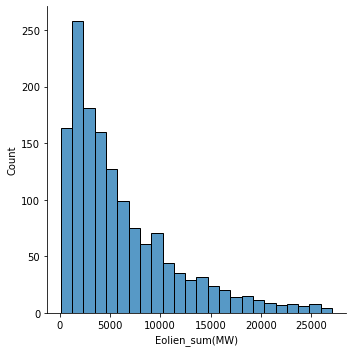

In [4]:
# Quelle est la distribution de la variable "Eolien (MW)"?

sns.displot(HDF['Eolien_sum(MW)']);

In [5]:
# on va grouper la production en quintiles
HDF["Eolien_groups"] = pd.qcut(x = HDF['Eolien_sum(MW)'], q=5,
                  labels = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

<ipython-input-5-2d5299909fcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HDF["Eolien_groups"] = pd.qcut(x = HDF['Eolien_sum(MW)'], q=5,


In [6]:
results, bins_edges = pd.qcut(x = HDF['Eolien_sum(MW)'], q=5, retbins=True)
print(bins_edges)

# Les groupes sont : 
# 112-1,818 MW / 1,818-3,355 MW / 3,355-5,611 MW / 5,611-9,793 MW / 9,793-27,094 MW
# on note que l'amplitude du dernier groupe est très grande

[  112.  1818.  3355.  5611.  9793. 27094.]


In [8]:
# selectionner les colonnes:
Data= HDF.drop(['Région','Date','Eolien_sum(MW)','Solaire_sum(MW)', 'Rayonnement_solaire_mean(W/m2)',
                'Consommation-sum(MW)','TMin (°C)','TMax (°C)'], axis=1)
Data_dummies = pd.get_dummies(data=Data, columns=['Annee', 'Month', 'Day'])
Data_dummies.head(3)

,Vitesse_vent_mean(m/s),TMoy (°C),Eolien_groups,Annee_2016,Annee_2017,Annee_2018,Annee_2019,Month_1,Month_2,Month_3,...,Month_10,Month_11,Month_12,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
7305,8.911429,4.72,Q3,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
7306,9.782500,8.51,Q5,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7307,10.170000,6.70,Q5,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [10]:
data = Data_dummies.drop('Eolien_groups', axis=1)
target = Data_dummies['Eolien_groups']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

# Création du modèle et recherche des meilleurs parametres

clf_rf = ensemble.RandomForestClassifier(random_state=22)
parametres_rf = {'n_estimators':[100, 250, 500, 1000],'max_features':['sqrt', 'log2'],'max_depth':[2, 4, 8]}
grid_clf_rf = model_selection.GridSearchCV(estimator=clf_rf, param_grid=parametres_rf, scoring='accuracy', cv = 5)
grille_rf = grid_clf_rf.fit(X_train,y_train)
print(grid_clf_rf.best_params_)

{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}


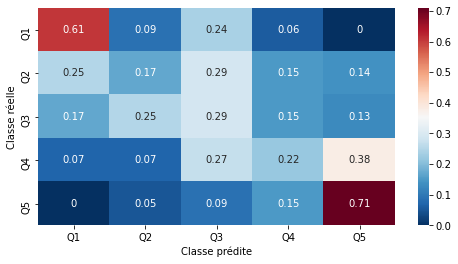

In [15]:
# appliquer le modèle au test set
y_pred = grid_clf_rf.predict(X_test)
# matrice de confusion
table = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize = 0).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#39_-_RF_confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()
# On voit des bonnes nombres de bonnes predictions pour Q1 & Q5

In [12]:
# score
grid_clf_rf.score(X_test, y_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# la précision moyenne = 0.39 (Q1 : 0.60)
# Recall = 0.41 (Q5 : 0.82)
# F1 score moyen = 0.38 (Q1 : 0.63)

              precision    recall  f1-score   support

          Q1       0.59      0.61      0.60        67
          Q2       0.28      0.17      0.21        59
          Q3       0.22      0.29      0.25        52
          Q4       0.31      0.22      0.25        60
          Q5       0.51      0.71      0.59        55

    accuracy                           0.40       293
   macro avg       0.38      0.40      0.38       293
weighted avg       0.39      0.40      0.39       293



## K nearest neighbours Classifier

In [16]:
Data.head(3)

,Annee,Month,Day,Vitesse_vent_mean(m/s),TMoy (°C),Eolien_groups
7305,2016,1,Friday,8.911429,4.72,Q3
7306,2016,1,Saturday,9.782500,8.51,Q5
7307,2016,1,Sunday,10.170000,6.70,Q5


In [18]:
# Separer target & variables explicatives 
data = Data.drop('Eolien_groups', axis=1)
target = Data['Eolien_groups']

# Preparation des données :
Categories = data[['Annee','Month', 'Day']]
data = data.drop(['Annee','Month','Day'], axis=1)

from sklearn import model_selection, preprocessing
scaler = preprocessing.StandardScaler().fit(data)
data[data.columns] = pd.DataFrame(scaler.transform(data), index=data.index)

data = data.join(Categories)
data = pd.get_dummies(data=data, columns=['Annee', 'Month', 'Day'])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

In [19]:
# Création du classifieur & recherche des meilleurs parametres
from sklearn import neighbors
from sklearn import model_selection
from sklearn import datasets
import numpy as np

score_minko = []
score_man = []
score_cheb = []

for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score_minko.append(knn.score(X_test, y_test))

for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train, y_train)
    score_man.append(knn.score(X_test, y_test))
    
for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train, y_train)
    score_cheb.append(knn.score(X_test, y_test))

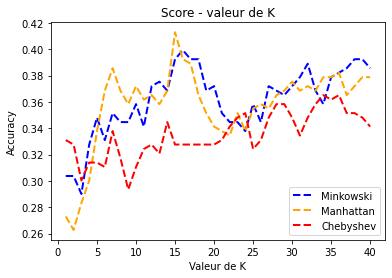

In [20]:
plt.plot(range(1, 41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1, 41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1, 41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();

In [21]:
# Application du modèle avec k=15, distance Manhattan
knn = neighbors.KNeighborsClassifier(n_neighbors=15, metric='manhattan')
knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
score
# avec ces parametres on obtient un score de 41%

0.4129692832764505

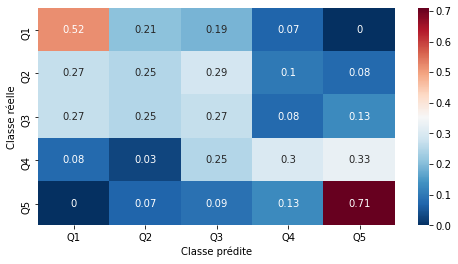

In [24]:
y_pred = knn.predict(X_test)
# matrice de confusion
table = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'], normalize = 0).round(2)
plt.figure(figsize=(8,4))
sns.heatmap(table, annot=True, cmap='RdBu_r')
plt.savefig("Pictures/#40_-_KNN_confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          Q1       0.50      0.52      0.51        67
          Q2       0.31      0.25      0.28        59
          Q3       0.22      0.27      0.24        52
          Q4       0.45      0.30      0.36        60
          Q5       0.55      0.71      0.62        55

    accuracy                           0.41       293
   macro avg       0.41      0.41      0.40       293
weighted avg       0.41      0.41      0.41       293

